### Name : Mohammad Hossein Sameti
### STID : 401204932


In [2]:
!gdown https://drive.google.com/u/0/uc?id=1-2cN6EuFQnIM53q1N3MQCVcoid1NPBWk&export=download


Downloading...
From: https://drive.google.com/u/0/uc?id=1-2cN6EuFQnIM53q1N3MQCVcoid1NPBWk
To: /content/test.pickle
100% 241M/241M [00:01<00:00, 179MB/s]


In [3]:
!gdown https://drive.google.com/u/0/uc?id=1Le3PVfeXWL8ZRDTy3JzGmPCnS49pCjxw&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1Le3PVfeXWL8ZRDTy3JzGmPCnS49pCjxw
To: /content/train.pickle
100% 1.93G/1.93G [00:08<00:00, 230MB/s]


In [4]:
!gdown https://drive.google.com/u/0/uc?id=1i9Ei3QSmPBnYzqknvZPg_6TNsPomxQYG&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1i9Ei3QSmPBnYzqknvZPg_6TNsPomxQYG
To: /content/train.pickle
100% 1.93G/1.93G [00:07<00:00, 248MB/s]


In [5]:
!gdown https://drive.google.com/u/0/uc?id=1-0bl_TuSM-JQ4nCwAW7ySn3uYMAGlaz4&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1-0bl_TuSM-JQ4nCwAW7ySn3uYMAGlaz4
To: /content/validation.pickle
100% 241M/241M [00:01<00:00, 169MB/s]


In [6]:
!pip install evaluate pytorch_metric_learning wandb

In [7]:
import wandb
wandb.login()

wandb: Currently logged in as: mh-sameti199. Use `wandb login --relogin` to force relogin


True

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import evaluate
from pytorch_metric_learning import losses
from torch.optim import lr_scheduler
from torchsummary import summary

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
train = pd.read_pickle('/content/train.pickle')
validation = pd.read_pickle('/content/validation.pickle')
test = pd.read_pickle('/content/test.pickle')

In [12]:
X_train = np.array([i[0] for i in train])
Y_train = np.array([i[1] for i in train]) -1
X_validation = np.array([i[0] for i in validation])
Y_validation = np.array([i[1] for i in validation])-1
X_test = np.array([i[0] for i in test])
Y_test = np.array([i[1] for i in test])-1

In [12]:
print(X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape, X_test.shape, Y_test.shape)

(2451, 512, 512, 3) (2451,) (306, 512, 512, 3) (306,) (307, 512, 512, 3) (307,)


In [13]:
np.unique(Y_train)

array([0, 1, 2])

# Showing 3 Image of Each Class

In [13]:
X_1 = X_train[Y_train == 0][:3]
X_2 = X_train[Y_train == 1][:3]
X_3 = X_train[Y_train == 2][:3]

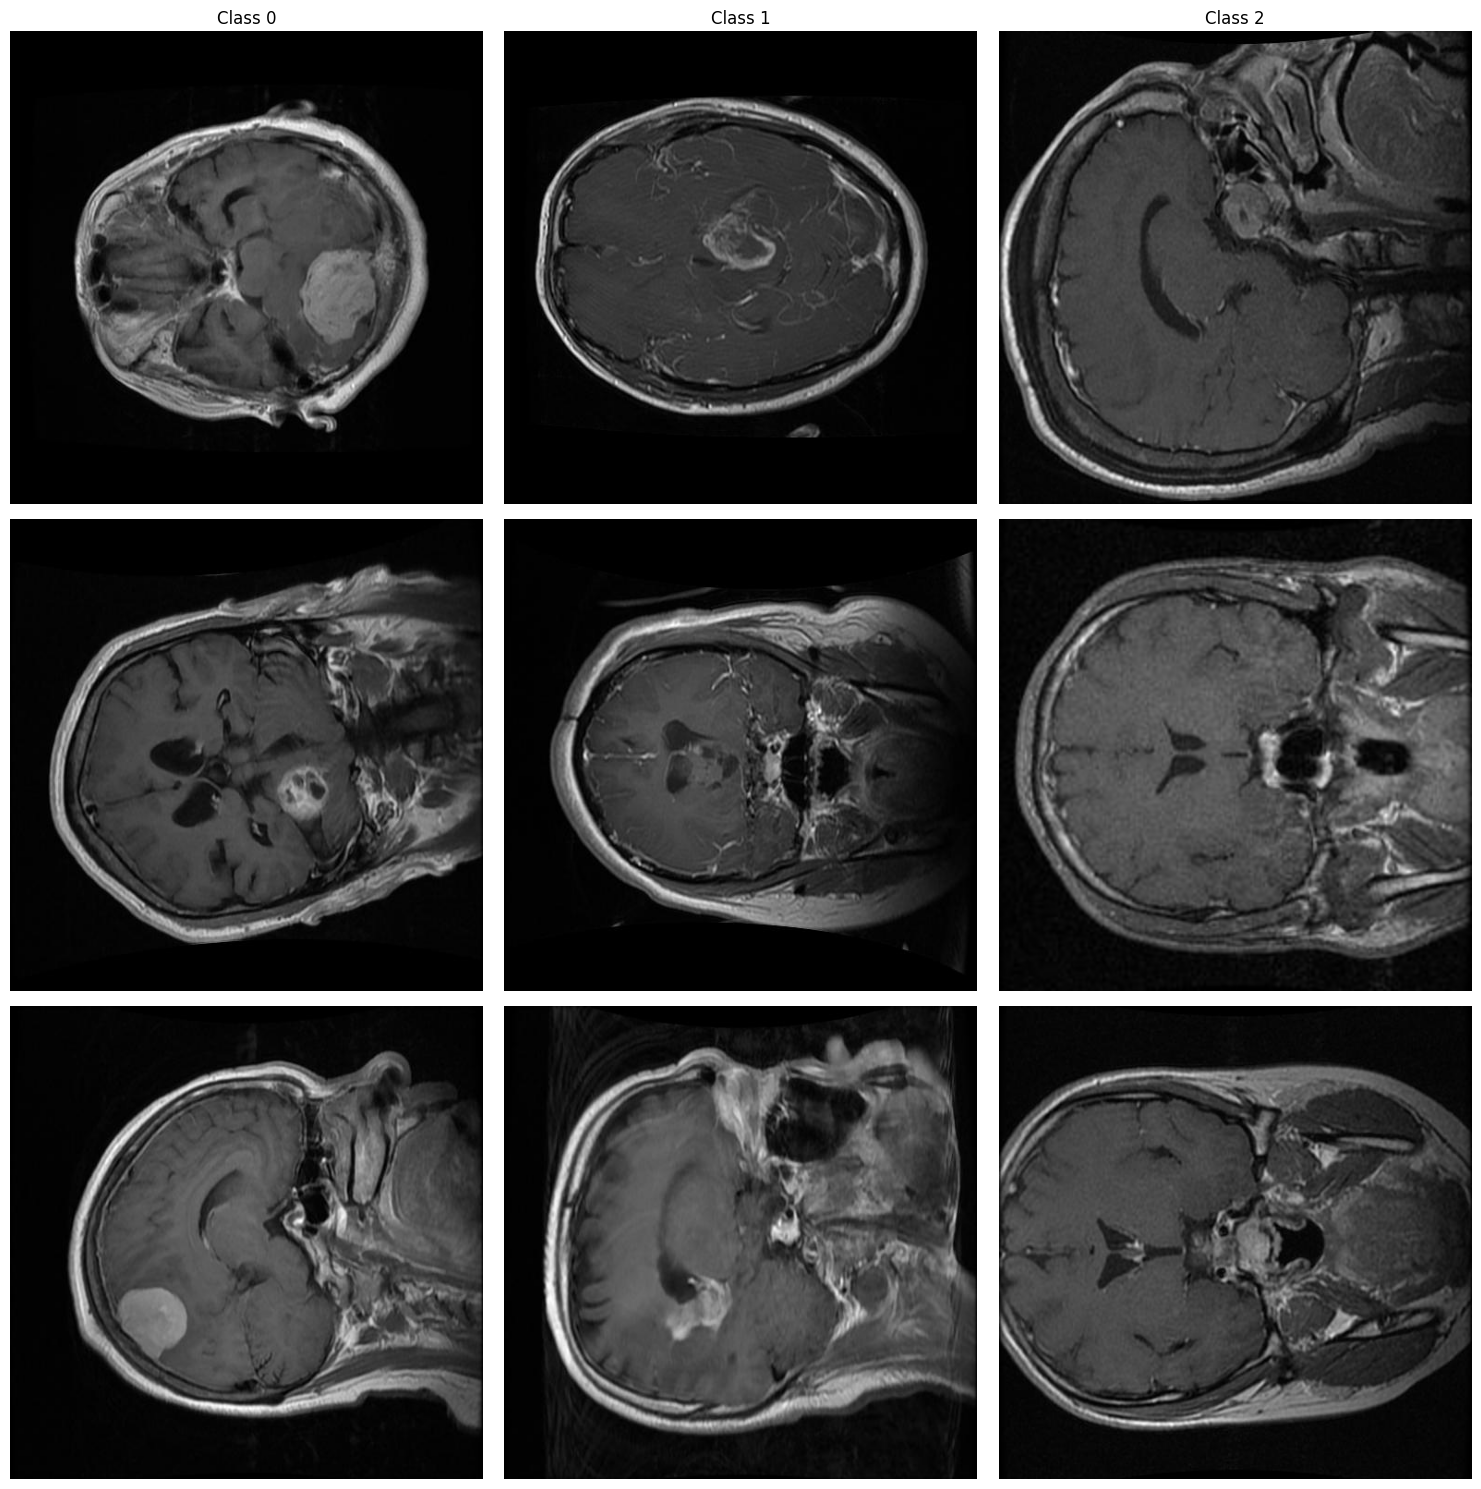

In [14]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
ax[0,0].imshow(X_1[0])
ax[1,0].imshow(X_1[1])
ax[2,0].imshow(X_1[2])
ax[0,1].imshow(X_2[0])
ax[1,1].imshow(X_2[1])
ax[2,1].imshow(X_2[2])
ax[0,2].imshow(X_3[0])
ax[1,2].imshow(X_3[1])
ax[2,2].imshow(X_3[2])
for i in range(3):
  for j in range(3):
    ax[i,j].axis('off')
ax[0,0].title.set_text("Class 0")
ax[0,1].title.set_text("Class 1")
ax[0,2].title.set_text("Class 2")
fig.tight_layout()

#DataLoader

In [15]:
class ImageDataset(Dataset):
  def __init__(self, data_x, data_y, transform=None):
    self.data_x = data_x
    self.data_y = data_y
    self.transform = transform
  def __len__(self):
    return len(self.data_x)
  def __getitem__(self, idx):
    return self.transform(self.data_x[idx]), torch.tensor(self.data_y[idx], dtype=torch.float64)

transform = transforms.ToTensor()

train_dataset = ImageDataset(X_train, Y_train, transform=transform)
validation_dataset = ImageDataset(X_validation, Y_validation, transform=transform)
test_dataset = ImageDataset(X_test, Y_test, transform=transform)



In [15]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

2451 306 307


In [16]:
BATCH_SIZE = 200
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
sample = next(iter(train_dataloader))

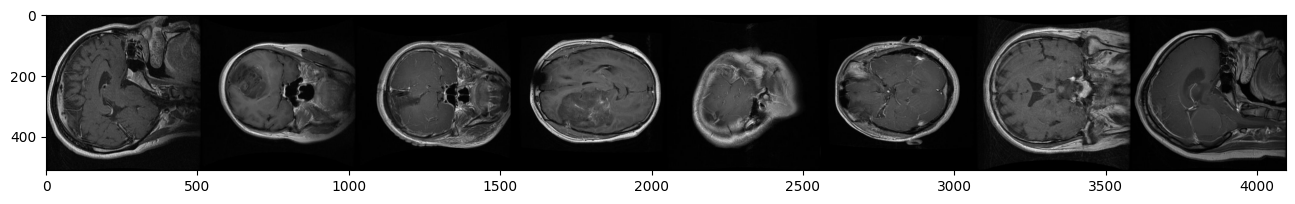

In [19]:
def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

plot_images(sample[0][:8])

### Finetuning PreTrained AlexNet

In [38]:
class AlexNetPreTrain(nn.Module):
  def __init__(self):
    super(AlexNetPreTrain, self).__init__()
    self.AlexNet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    self.fc = nn.Linear(1000, 3)
  def forward(self, x):
    x = self.AlexNet(x)
    x = F.relu(x)
    x = self.fc(x)
    return F.softmax(x)
model = AlexNetPreTrain()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [18]:
def Train(model, loader, criterion, opt, device, p=True):
  model.train()
  Loss = 0
  acc = evaluate.load('accuracy')
  for data, target in loader:
      target = target.type(torch.LongTensor)
      data, target = data.to(device), target.to(device)
      opt.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      Loss += loss.sum().item()
      loss.backward()
      opt.step()
      acc.add_batch(references=target, predictions=output.argmax(axis=1))

      data.cpu()
      target.cpu()
  if p:
    a = acc.compute()['accuracy']
    return Loss / len(loader), a
  return Loss / len(loader)


def Validate(model, loader, criterion, device):
  model.eval()
  Loss = 0
  acc = evaluate.load('accuracy', average=None)
  metric = evaluate.combine([
    evaluate.load('f1', average=None),
    evaluate.load('precision', average=None),
    evaluate.load('recall', average=None)])
  with torch.no_grad():
    for data, target in loader:
      target = target.type(torch.LongTensor)
      data, target = data.to(device), target.to(device)

      output = model(data)

      loss = criterion(output, target)
      Loss += loss.sum().item()
      metric.add_batch(references=target, predictions=output.argmax(axis=1))
      acc.add_batch(references=target, predictions=output.argmax(axis=1))
      #data.to('cpu'); target.to('cpu')
      data.cpu()
      target.cpu()
    met = metric.compute(average=None)
    f1 = ['%.3f' % n for n in met['f1']]
    p = ['%.3f' % n for n in met['precision']]
    r = ['%.3f' % n for n in met['recall']]
    print(f"F1 : {f1}, \t Precision : {p}, \t Recall : {r} ")
    wandb.log({f"{model.__class__.__name__}_Validation_f1_class0": float(f1[0]), f"{model.__class__.__name__}_Validation_f1_class1": float(f1[1]), f"{model.__class__.__name__}_Validation_f1_class2": float(f1[2]),
               f"{model.__class__.__name__}_Validation_Precision_class0": float(p[0]), f"{model.__class__.__name__}_Validation_Precision_class1": float(p[1]), f"{model.__class__.__name__}_Validation_Precision_class2": float(p[2]),
               f"{model.__class__.__name__}_Validation_Recall_class0": float(r[0]), f"{model.__class__.__name__}_Validation_Recall_class1": float(r[1]), f"{model.__class__.__name__}_Validation_Recall_class2": float(r[2])})
  return Loss / len(loader), acc.compute()['accuracy']




In [17]:
wandb.init(
    project='SPB_HW2',
    config={
    "learning_rate": 0.0001,
    "architecture": "AlexNet",
    "dataset": "",
    "epochs": 10}
)

In [41]:
# train
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
epochs = 10
model.to(device)
Train_loss = []
val_loss = []
Train_acc = []
val_acc = []
for epoch in range(epochs):
    print(f'epoch {epoch+1}:')
    tl, ta = Train(model, train_dataloader, criterion, optimizer, device)
    vl, va = Validate(model, val_dataloader, criterion, device)
    scheduler.step(vl)
    Train_loss.append(tl)
    val_loss.append(vl)
    Train_acc.append(ta)
    val_acc.append(va)
    print(f'Training Loss {tl:.3f} \t Training Accuracy {ta:.3f} \t Validation Loss {vl:.3f} \t Validation Accuracy {va:.3f}')
    wandb.log({f"{model.__class__.__name__}_Train_Accuracy": ta, f"{model.__class__.__name__}_Train_loss": tl, f"{model.__class__.__name__}_Validation_Accuracy": va, f"{model.__class__.__name__}_Validation_loss": vl})


epoch 1:
F1 : ['0.000', '0.751', '0.724'], 	 Precision : ['0.000', '0.728', '0.568'], 	 Recall : ['0.000', '0.775', '1.000'] 
Training Loss 0.943 	 Training Accuracy 0.592 	 Validation Loss 0.903 	 Validation Accuracy 0.647
epoch 2:
F1 : ['0.000', '0.799', '0.920'], 	 Precision : ['0.000', '0.675', '0.869'], 	 Recall : ['0.000', '0.979', '0.977'] 
Training Loss 0.815 	 Training Accuracy 0.738 	 Validation Loss 0.797 	 Validation Accuracy 0.735
epoch 3:
F1 : ['0.774', '0.878', '0.945'], 	 Precision : ['0.707', '0.958', '0.915'], 	 Recall : ['0.855', '0.810', '0.977'] 
Training Loss 0.721 	 Training Accuracy 0.830 	 Validation Loss 0.690 	 Validation Accuracy 0.869
epoch 4:
F1 : ['0.750', '0.894', '0.920'], 	 Precision : ['0.750', '0.931', '0.869'], 	 Recall : ['0.750', '0.859', '0.977'] 
Training Loss 0.671 	 Training Accuracy 0.878 	 Validation Loss 0.680 	 Validation Accuracy 0.866
epoch 5:
F1 : ['0.753', '0.841', '0.950'], 	 Precision : ['0.636', '1.000', '0.925'], 	 Recall : ['0.921

In [50]:
vl, va = Validate(model, test_dataloader, criterion, device)
print(f'Test Accuracy {va:.3f}')

F1 : ['0.840', '0.926', '0.951'], 	 Precision : ['0.763', '0.992', '0.939'], 	 Recall : ['0.934', '0.868', '0.963'] 
Test Accuracy 0.909


Loss Diagram


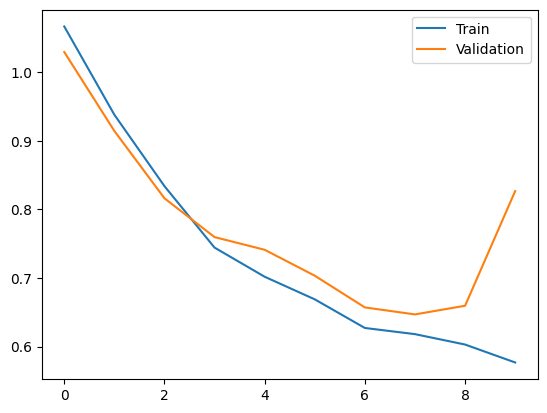

In [51]:
print('Loss Diagram')
plt.plot(Train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.show()

Accuracy Diagram


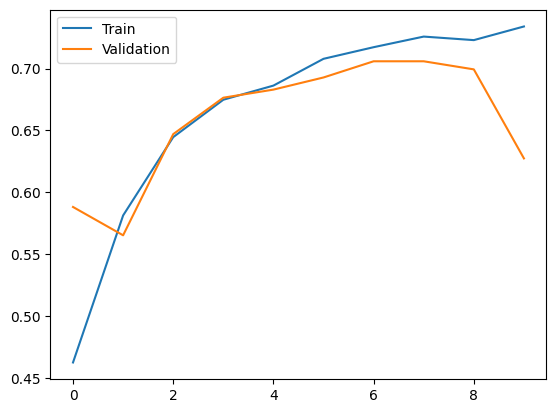

In [52]:
print('Accuracy Diagram')
plt.plot(Train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def Display_confusion(Data, model):
  model.eval()
  preds = []
  Trues = []
  with torch.no_grad():
    for data, target in Data:
      target = target.type(torch.LongTensor)
      data, target = data.to(device), target.to(device)
      output = model(data)
      preds += output.argmax(axis=1).tolist()
      Trues += target.tolist()
  cm = confusion_matrix(Trues, preds)
  ConfusionMatrixDisplay(cm).plot()

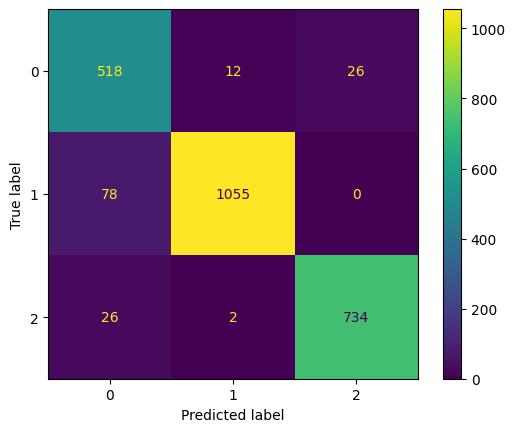

In [54]:
Display_confusion(train_dataloader, model)

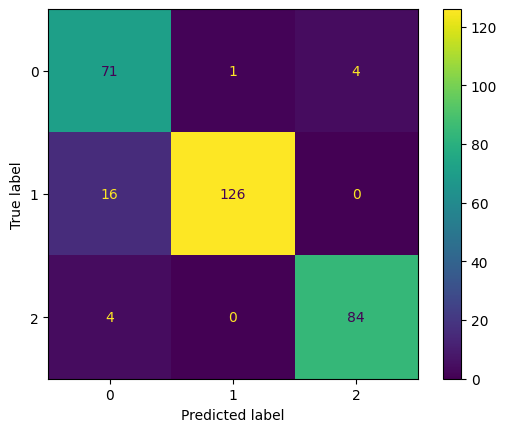

In [55]:
Display_confusion(val_dataloader, model)

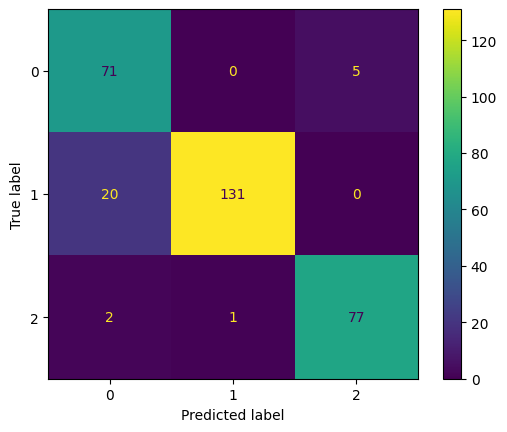

In [56]:
Display_confusion(test_dataloader, model)

### Train AlexNEt From Scratch

In [42]:
class AlexNetFromScratch(nn.Module):
  def __init__(self):
    super(AlexNetFromScratch, self).__init__()
    self.conv = nn.Sequential(nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    self.adaptive = nn.AdaptiveAvgPool2d(output_size=(6, 6))
    self.classifier = nn.Sequential(nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=9216, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=4096, out_features=1000, bias=True),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=1000, out_features=3, bias=True))



  def forward(self, x):
    x = self.conv(x)
    x = self.adaptive(x).reshape(-1, 9216)
    x = self.classifier(x)
    return x





In [43]:
Alex_f = AlexNetFromScratch()
Alex_f.to(device)
summary(Alex_f, (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 127, 127]          23,296
              ReLU-2         [-1, 64, 127, 127]               0
         MaxPool2d-3           [-1, 64, 63, 63]               0
            Conv2d-4          [-1, 192, 63, 63]         307,392
              ReLU-5          [-1, 192, 63, 63]               0
         MaxPool2d-6          [-1, 192, 31, 31]               0
            Conv2d-7          [-1, 384, 31, 31]         663,936
              ReLU-8          [-1, 384, 31, 31]               0
            Conv2d-9          [-1, 256, 31, 31]         884,992
             ReLU-10          [-1, 256, 31, 31]               0
           Conv2d-11          [-1, 256, 31, 31]         590,080
             ReLU-12          [-1, 256, 31, 31]               0
        MaxPool2d-13          [-1, 256, 15, 15]               0
AdaptiveAvgPool2d-14            [-1, 25

In [44]:
lr = 1e-4

optimizer = torch.optim.Adam(Alex_f.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
epochs = 10
Train_loss = []
val_loss = []
Train_acc = []
val_acc = []
for epoch in range(epochs):
    print(f'epoch {epoch+1}:')
    tl, ta = Train(Alex_f, train_dataloader, criterion, optimizer, device)
    vl, va = Validate(Alex_f, val_dataloader, criterion, device)
    scheduler.step(vl)
    Train_loss.append(tl)
    val_loss.append(vl)
    Train_acc.append(ta)
    val_acc.append(va)
    print(f'Training Loss {tl:.3f} \t Training Accuracy {ta:.3f} \t Validation Loss {vl:.3f} \t Validation Accuracy {va:.3f}')
    wandb.log({f"{Alex_f.__class__.__name__}_Train_Accuracy": ta, f"{Alex_f.__class__.__name__}_Train_loss": tl, f"{Alex_f.__class__.__name__}_Validation_Accuracy": va, f"{Alex_f.__class__.__name__}_Validation_loss": vl})


epoch 1:
F1 : ['0.000', '0.684', '0.638'], 	 Precision : ['0.000', '0.534', '0.849'], 	 Recall : ['0.000', '0.951', '0.511'] 
Training Loss 1.066 	 Training Accuracy 0.463 	 Validation Loss 1.029 	 Validation Accuracy 0.588
epoch 2:
F1 : ['0.102', '0.718', '0.561'], 	 Precision : ['0.143', '0.591', '0.841'], 	 Recall : ['0.079', '0.915', '0.420'] 
Training Loss 0.938 	 Training Accuracy 0.581 	 Validation Loss 0.914 	 Validation Accuracy 0.565
epoch 3:
F1 : ['0.000', '0.720', '0.777'], 	 Precision : ['0.000', '0.594', '0.782'], 	 Recall : ['0.000', '0.915', '0.773'] 
Training Loss 0.834 	 Training Accuracy 0.645 	 Validation Loss 0.816 	 Validation Accuracy 0.647
epoch 4:
F1 : ['0.000', '0.750', '0.813'], 	 Precision : ['0.000', '0.639', '0.750'], 	 Recall : ['0.000', '0.908', '0.886'] 
Training Loss 0.744 	 Training Accuracy 0.675 	 Validation Loss 0.759 	 Validation Accuracy 0.676
epoch 5:
F1 : ['0.000', '0.752', '0.829'], 	 Precision : ['0.000', '0.642', '0.762'], 	 Recall : ['0.000

In [45]:
vl, va = Validate(Alex_f, test_dataloader, criterion, device)
print(f'Test Accuracy {va:.3f}')

F1 : ['0.050', '0.750', '0.767'], 	 Precision : ['0.500', '0.695', '0.627'], 	 Recall : ['0.026', '0.815', '0.988'] 
Test Accuracy 0.664


Loss Diagram


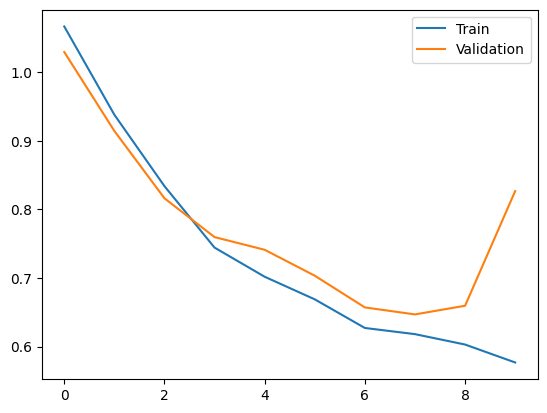

In [46]:
print('Loss Diagram')
plt.plot(Train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.show()

Accuracy Diagram


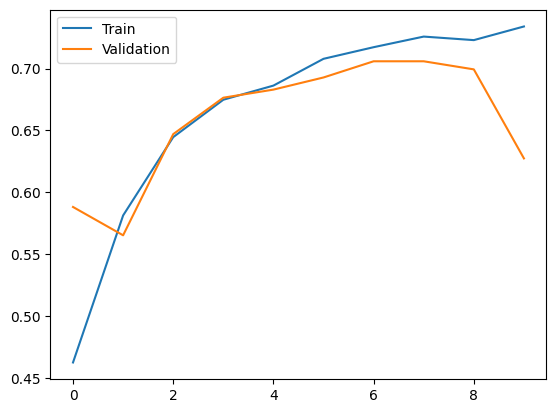

In [47]:
print('Accuracy Diagram')
plt.plot(Train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.show()

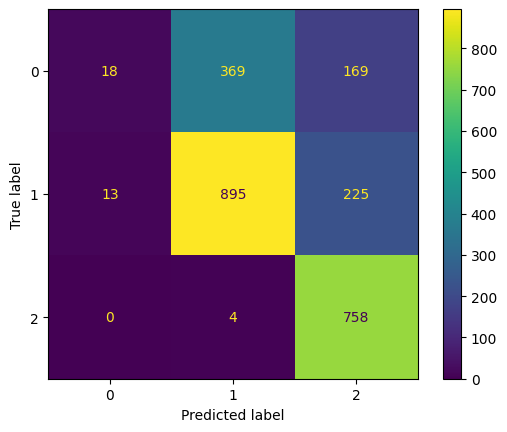

In [57]:
Display_confusion(train_dataloader, Alex_f)

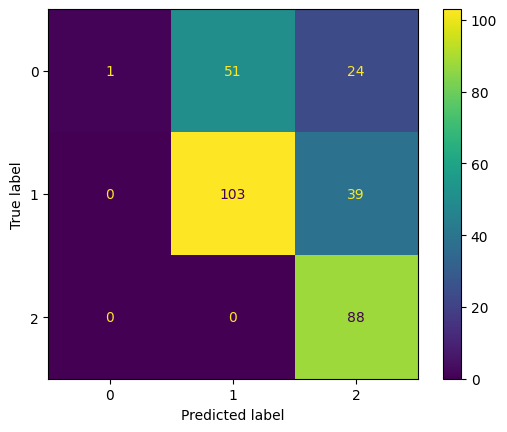

In [58]:
Display_confusion(val_dataloader, Alex_f)

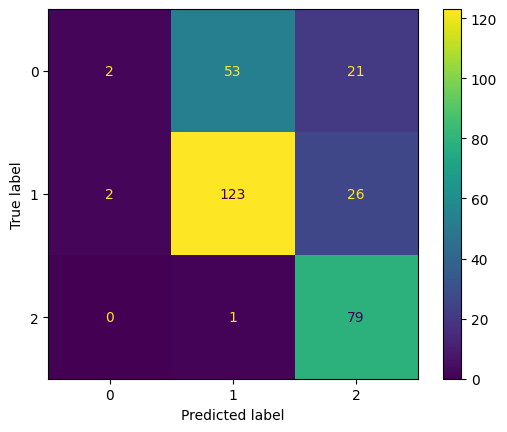

In [59]:
Display_confusion(test_dataloader, Alex_f)

In [61]:
model.cpu()
Alex_f.cpu()
print('')

### Train with SUpervised Contrastive Loss then fineTune with CrossEntropy Loss

In [20]:
class Alexx(nn.Module):
  def __init__(self):
    super(Alexx, self).__init__()
    self.conv = nn.Sequential(nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    self.adaptive = nn.AdaptiveAvgPool2d(output_size=(6, 6))
    self.classifier = None

  def forward(self, x):
    x = self.conv(x)
    x = self.adaptive(x).reshape(-1, 9216)
    if self.classifier is not None:
      x = self.classifier(x)
    return x


In [21]:
class SupervisedContrastiveLoss(nn.Module):
  def __init__(self, tempreture=0.1):
    super(SupervisedContrastiveLoss, self).__init__()
    self.tempreture = tempreture
  def forward(self, output, target, num_classes=3):
      # output: (160, 1000)
      # target: (160, 1)
      # P_i: (--, 1000)
      # P_i_j: (1000)
      output = F.normalize(output)
      loss = 0
      for i in range(target.shape[0]):
        P_i = output[target == target[i]] # samples with the same label in batch
        #print(P_i.shape, output.shape, torch.transpose(output[i:i+1], 0, 1).shape)
        negative_pairs = torch.sum(torch.exp(torch.matmul(output, torch.transpose(output[i:i+1], 0, 1)) / self.tempreture)) - (torch.exp(torch.inner(output[i:i+1], output[i:i+1]) / self.tempreture))# sum of similarities between sample i and all other samples (except i)
        sum_i = 0
        for j in range(P_i.shape[0]):
            positive_pair = torch.inner(output[i:i+1], output[j:j+1]) / self.tempreture # similarity between sample i and j
            sum_i += torch.log(positive_pair / negative_pairs)

        sum_i /= (- P_i.shape[0])

        loss += sum_i

      return loss


In [22]:
lr = 5e-3
alex2 = Alexx()
alex2.to(device)
optimizer = torch.optim.SGD(alex2.parameters(), lr=lr, weight_decay = 0.005, momentum = 0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = SupervisedContrastiveLoss(0.1)
epochs = 10
Train_loss = []
for epoch in range(epochs):
    print(f'epoch {epoch+1}:')
    tl = Train(alex2, train_dataloader, criterion, optimizer, device, p=False)
    scheduler.step(tl)
    Train_loss.append(tl)
    print(f'Loss : {tl:.4f}' )
    wandb.log({f"{alex2.__class__.__name__}_Train_Loss": tl})

epoch 1:
Loss : 2379.9780
epoch 2:
Loss : 2373.4780
epoch 3:
Loss : 2372.1198
epoch 4:
Loss : 2370.8025
epoch 5:
Loss : 2369.1739
epoch 6:
Loss : 2367.4582
epoch 7:
Loss : 2365.2381
epoch 8:
Loss : 2361.1724
epoch 9:
Loss : 2352.3190
epoch 10:
Loss : 2272.1545


In [23]:
alex2.classifier = nn.Sequential(
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=9216, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=4096, out_features=1000, bias=True),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=1000, out_features=3, bias=True))

alex2.to(device)
for param in alex2.conv.parameters():
  param.requires_grad = False

In [24]:
lr = 1e-4
optimizer = torch.optim.Adam(alex2.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
epochs = 5
Train_loss = []
val_loss = []
Train_acc = []
val_acc = []
for epoch in range(epochs):
    print(f'epoch {epoch+1}:')
    tl, ta = Train(alex2, train_dataloader, criterion, optimizer, device)
    vl, va = Validate(alex2, val_dataloader, criterion, device)
    scheduler.step(vl)
    Train_loss.append(tl)
    val_loss.append(vl)
    Train_acc.append(ta)
    val_acc.append(va)
    print(f'Training Loss {tl:.3f} \t Training Accuracy {ta:.3f} \t Validation Loss {vl:.3f} \t Validation Accuracy {va:.3f}')
    wandb.log({f"{alex2.__class__.__name__}_Train_Accuracy": ta, f"{alex2.__class__.__name__}_Train_loss": tl, f"{alex2.__class__.__name__}_Validation_Accuracy": va, f"{alex2.__class__.__name__}_Validation_loss": vl})


epoch 1:
F1 : ['0.398', '0.000', '0.000'], 	 Precision : ['0.248', '0.000', '0.000'], 	 Recall : ['1.000', '0.000', '0.000'] 
Training Loss 848.432 	 Training Accuracy 0.475 	 Validation Loss 166.928 	 Validation Accuracy 0.248
epoch 2:
F1 : ['0.118', '0.690', '0.619'], 	 Precision : ['0.231', '0.559', '0.843'], 	 Recall : ['0.079', '0.901', '0.489'] 
Training Loss 81.999 	 Training Accuracy 0.468 	 Validation Loss 30.707 	 Validation Accuracy 0.578
epoch 3:
F1 : ['0.187', '0.564', '0.659'], 	 Precision : ['0.323', '0.687', '0.494'], 	 Recall : ['0.132', '0.479', '0.989'] 
Training Loss 23.813 	 Training Accuracy 0.545 	 Validation Loss 7.641 	 Validation Accuracy 0.539
epoch 4:
F1 : ['0.286', '0.540', '0.669'], 	 Precision : ['0.360', '0.726', '0.506'], 	 Recall : ['0.237', '0.430', '0.989'] 
Training Loss 10.740 	 Training Accuracy 0.530 	 Validation Loss 4.220 	 Validation Accuracy 0.542
epoch 5:
F1 : ['0.438', '0.642', '0.776'], 	 Precision : ['0.457', '0.691', '0.690'], 	 Recall :

In [25]:
vl, va = Validate(alex2, test_dataloader, criterion, device)
print(f'Test Accuracy {va:.3f}')

F1 : ['0.394', '0.629', '0.781'], 	 Precision : ['0.424', '0.682', '0.670'], 	 Recall : ['0.368', '0.583', '0.938'] 
Test Accuracy 0.622


Loss Diagram


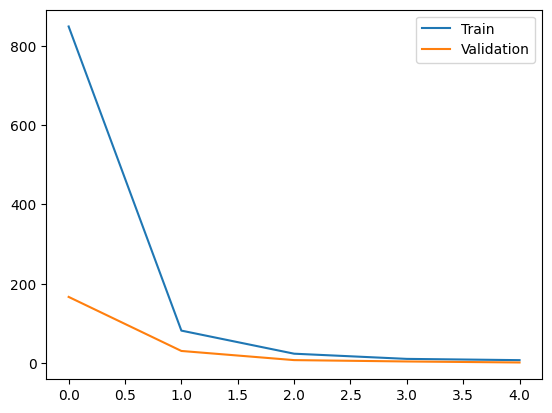

In [26]:
print('Loss Diagram')
plt.plot(Train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.show()

Accuracy Diagram


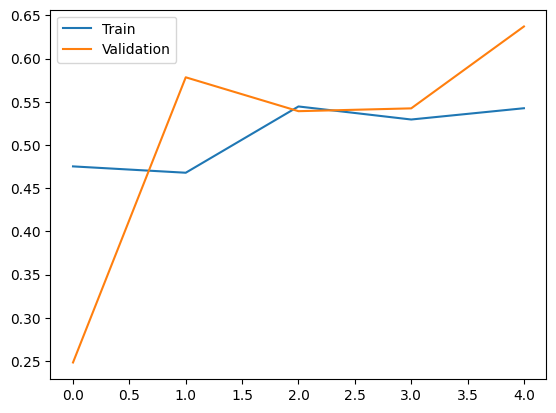

In [27]:
print('Accuracy Diagram')
plt.plot(Train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.show()

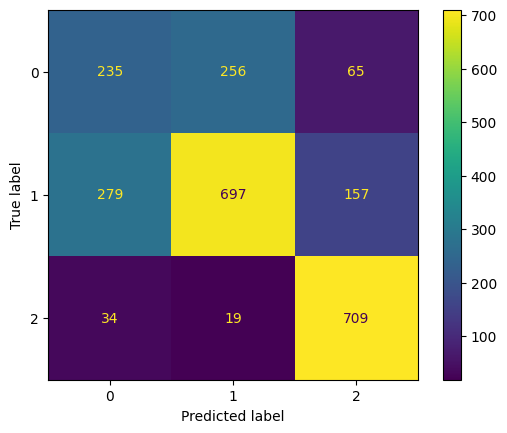

In [28]:
Display_confusion(train_dataloader, alex2)

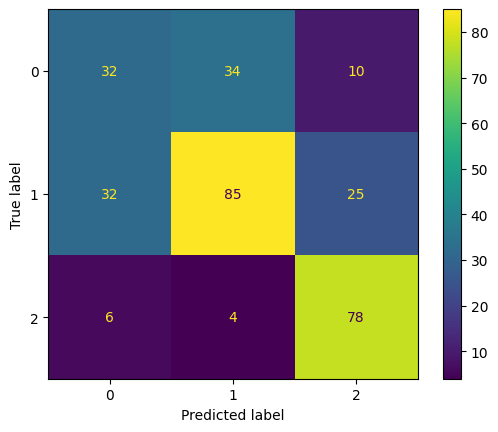

In [29]:
Display_confusion(val_dataloader, alex2)

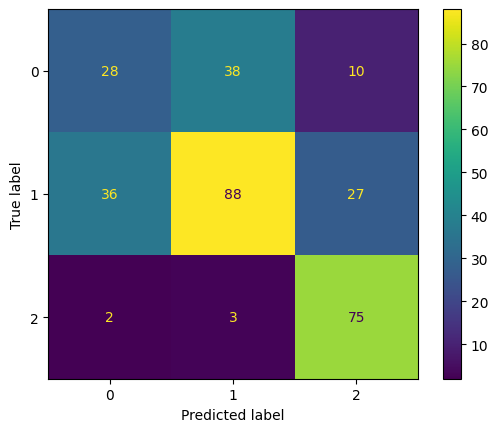

In [30]:
Display_confusion(test_dataloader, alex2)

In [31]:
wandb.finish()

Alexx_Train_Accuracy,▂▁█▇█
Alexx_Train_Loss,██▇▇▇▇▇▇▆▁
Alexx_Train_loss,█▂▁▁▁
Alexx_Validation_Accuracy,▁▇▆▆█
Alexx_Validation_Precision_class0,▂▁▄▅█▇
Alexx_Validation_Precision_class1,▁▆████
Alexx_Validation_Precision_class2,▁█▅▅▇▇
Alexx_Validation_Recall_class0,█▁▁▂▄▃
Alexx_Validation_Recall_class1,▁█▅▄▆▆
Alexx_Validation_Recall_class2,▁▄██▇█
Alexx_Validation_f1_class0,▇▁▃▅█▇
